In [1]:
# !pip install git+git://github.com/StochSS/sciope.git@master
import numpy as np
import sys
sys.path.insert(1, '/home/smatthe2/sciope')
sys.path.insert(1, '/home/smatthe2/GillesPy2')
import sciope
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

# devils_2stage_inference

In [2]:
variables = {
    "juvenile_concentration": 0.467,
    "infected_concentration": 5e-5,
    "birth_rate": 0.055,
    "incubation": 22.6,
    "progression": 12,
    "infection_rate": 2e-05,
    "maturity_rate": 0.04267,
    "death_rate_juvenile": 0.006,
    "death_rate_susceptible": 0.02335,
    "death_rate_susceptible2": 2.3e-7,
    "death_rate_infected": 0.03,
    "death_rate_diseased": 0.048,
    "dftd_start": 40
}

variables_orig = variables.copy()

In [3]:
import pandas as pd

# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values[40:])
init_devils_pop = devil_pop[0]
# dftd_pop = .1*init_devils_pop

# model.listOfParameters['K'].expression = max(devil_pop)*1.3

# model.listOfSpecies['Devils'].initial_value = init_devils_pop
# model.listOfSpecies['I'].initial_value = round(init_devils_pop*.001)  # This will be overwritten by variables later
# model.listOfSpecies['S'].initial_value = round(init_devils_pop*.999)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
print(obs)

[[[42281.25886 42721.08577 42909.58301 43035.24784 43286.57751
   43412.24234 43663.572   43789.23683 43977.73407 44040.56649
   44166.23132 44229.06374 44354.72857 44417.56098 44480.3934
   44543.22581 44668.89064 44668.89064 44794.55547 44794.55547
   44920.22031 44983.05272 45108.71755 45422.87963 45611.37688
   45737.04171 45862.70654 46051.20378 46239.70103 46365.36586
   46428.19828 46616.69552 46805.19277 46930.8576  47370.68451
   47559.18175 47810.51141 47936.17624 48187.50591 48376.00315
   48501.66798 48690.16523 48878.66248 49067.15972 49318.48938
   49569.81904 49632.65146 49695.48388 49821.14871 49821.14871
   49883.98112 49946.81354 50072.47837 50135.31078 50198.1432
   50323.80803 50449.47286 50512.30528 50637.97011 50763.63494
   50889.29977 51014.9646  51140.62943 51266.29426 51391.95909
   51517.62392 51643.28875 51894.61841 51957.45083 52020.28325
   52083.11566 52145.94808 52208.78049 52334.44532 52334.44532
   52334.44532 52460.11015 52460.11015 52585.77498 52585.

In [4]:
class Devilsv101(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils Pre-Vaccination")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        carrying_capacity = Parameter(name="carrying_capacity", expression=int(max(devil_pop)*1.16))
        #print("carrying_capacity={0}".format(carrying_capacity.value))
        death_rate_susceptible = Parameter(name="death_rate_susceptible",expression=values['death_rate_susceptible'])
        death_rate_susceptible2 = Parameter(name="death_rate_susceptible2",expression=values['death_rate_susceptible2'])
        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        incubation = Parameter(name="incubation", expression=values['incubation'])
        progression = Parameter(name="progression", expression=values['progression'])
        infection_rate = Parameter(name="infection_rate", expression=values['infection_rate'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        self.add_parameter([birth_rate, carrying_capacity, death_rate_susceptible, 
                            death_rate_susceptible2, death_rate_juvenile, death_rate_infected,
                            death_rate_diseased, incubation, progression, 
                            infection_rate, maturity_rate])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        J_pop = round(initial_devil_population*values['juvenile_concentration'])
        init_S_pop = initial_devil_population - J_pop
        I_pop = max(round(init_S_pop * variables['infected_concentration']),1) #must have at least 1
        S_pop = init_S_pop - I_pop
        
        Juvenile = Species(
            name="Juvenile", initial_value=J_pop, 
            mode="discrete"
        )
        Susceptible = Species(
            name="Susceptible", initial_value=S_pop,
            mode="discrete"
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=I_pop, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

        # Reactions
#         Birth = Reaction(name="Birth",
#             reactants={}, products={'Juvenile': 1, 'Devils': 1},
#             propensity_function="birth_r2ate*(Susceptible + Exposed + Infected)*\
#                                  (1-(Susceptible + Exposed + Infected)/carrying_capacity)"
#         )
        Birth1 = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate*(Susceptible+Exposed+Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        self.add_reaction([Birth1, Mature])
        
    
    
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible2*(Juvenile)*(Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible* Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible2*(Susceptible)*(Devils-1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected*Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible2*(Infected)*(Devils-1)"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased*Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible2*(Diseased)*(Devils-1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible*Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible2*(Exposed)*(Devils-1)"
        )
        self.add_reaction([
                           Death_Juvenile,    Death_Juvenile2,
                           Death_Susceptible, Death_Susceptible2, 
                           Death_Exposed,     Death_Exposed2,
                           Death_Infected,    Death_Infected2,
                           Death_Diseased,    Death_Diseased2,
                          ])
        
        
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
            propensity_function="infection_rate*Susceptible*Infected"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased':1},
            propensity_function="infection_rate*Susceptible*Diseased"
        )
        Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed/incubation"
        )
        Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected/progression"
        )
        self.add_reaction([TransmissionI, TransmissionD, Stage1, Stage2])

        # Events
        if events is not None:
            self.add_event(events)
            # Add check to end simulation if we excede carying capacity
            self.add_event(Event(name="exceed_carrying_capacity", 
                trigger = EventTrigger(expression="Devils >= 2*carrying_capacity"),
                assignments = [
                    EventAssignment(variable="Devils", expression=1),
                    EventAssignment(variable="Juvenile", expression=0),
                    EventAssignment(variable="Susceptible", expression=0),
                    EventAssignment(variable="Exposed", expression=0),
                    EventAssignment(variable="Infected", expression=0),
                ]
            ))

            # Timespan
        self.timespan(np.linspace(0, 380, 381)) # month data tspan

In [5]:
model = Devilsv101()
print(model)

Devils Pre-Vaccination

**********
Species
**********

Devils: 42281
Diseased: 0
Exposed: 0
Infected: 1
Juvenile: 19745
Susceptible: 22535

**********
Parameters
**********

birth_rate: 0.055
carrying_capacity: 61874
death_rate_diseased: 0.048
death_rate_infected: 0.03
death_rate_juvenile: 0.006
death_rate_susceptible2: 2.3e-07
death_rate_susceptible: 0.02335
incubation: 22.6
infection_rate: 2e-05
maturity_rate: 0.04267
progression: 12

**********
Reactions
**********

Birth
	Products
		Juvenile: 1
		Devils: 1
	Propensity Function: (birth_rate*((Susceptible+Exposed)+Infected))
DFTD_Stage1
	Reactants
		Exposed: 1
	Products
		Infected: 1
	Propensity Function: (Exposed/incubation)
DFTD_Stage2
	Reactants
		Infected: 1
	Products
		Diseased: 1
	Propensity Function: (Infected/progression)
Death_Diseased
	Reactants
		Diseased: 1
		Devils: 1
	Propensity Function: (death_rate_diseased*Diseased)
Death_Diseased2
	Reactants
		Diseased: 1
		Devils: 1
	Propensity Function: ((death_rate_susceptible2*D

# Model Inference

In [6]:
%load_ext autoreload
%autoreload 2

from tsfresh.feature_extraction.settings import MinimalFCParameters
from sciope.utilities.priors import uniform_prior
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared, euclidean, manhattan
from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.utilities.epsilonselectors import RelativeEpsilonSelector
from sklearn.metrics import mean_absolute_error
import dask
from dask.distributed import Client

## Generate some fixed(observed) data based on default parameters of the model

In [7]:
def configure_simulation():
    solver = SSACSolver(model=model, variable=True)
    kwargs = {
        "solver":solver,
#         "number_of_trajectories":100,
#         "seed":None,
#         "tau_tol":0.03,
#         "integrator_options":{'rtol': 0.001, 'atol': 1e-06}
    }
    return kwargs

In [8]:
kwargs = configure_simulation()

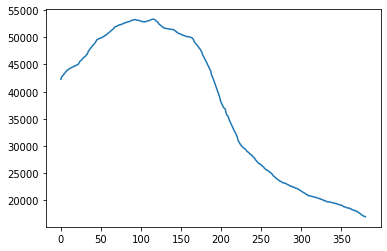

In [9]:
plt.plot(model.tspan, devil_pop)
# plt.plot(model.tspan, dfdt_pop)

In [10]:
solver = SSACSolver(model, variable=True)

In [11]:
results = model.run(solver=solver)
results.plotplotly()

## Define prior distribution

In [12]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

print(default_param)

parameter_names = []
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

print(parameter_names)
print(bound)
# bound = np.log(bound)
# Set the bounds
bound = np.array(bound)
dmin = np.log(bound * 0.5)
dmax = np.log(bound * 5.0)
# dmin = bound * 0.5
# dmax = bound * 5.0

print(dmin)
print(dmax)
# Here we use uniform prior
uni_prior = uniform_prior.UniformPrior(dmin, dmax)

['birth_rate', 'carrying_capacity', 'death_rate_diseased', 'death_rate_infected', 'death_rate_juvenile', 'death_rate_susceptible2', 'death_rate_susceptible', 'incubation', 'infection_rate', 'maturity_rate', 'progression']
[0.055, 61874.0, 0.048, 0.03, 0.006, 2.3e-07, 0.02335, 22.6, 2e-05, 0.04267, 12.0]
[ -3.59356927  10.33970816  -3.72970145  -4.19970508  -5.80914299
 -15.97833371  -4.45030548   2.42480273 -11.51292546  -3.84740636
   1.79175947]
[ -1.29098418  12.64229325  -1.42711636  -1.89711998  -3.5065579
 -13.67574862  -2.14772038   4.72738782  -9.21034037  -1.54482127
   4.09434456]


In [13]:
# parameter_names = ['r',    'K',   'L',   'k0']
# lower_bounds =    [.002,   45000, .003,  .06]
# upper_bounds =    [.04,    75000, .04,   .7]
# uni_prior = uniform_prior.UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Define simulator

In [14]:
def set_model_parameters(params):
    # params - array, need to have the same order as model.listOfParameters
    variables = dict(zip(parameter_names, params))
    return variables

# Here we use the GillesPy2 Solver
def simulator(params, model):
    print('testing params:\n', params)
    params = np.exp(params)
    variables = set_model_parameters(params)
#     model_update = set_model_parameters(params, model)

    res = model.run(**kwargs, variables=variables)
#     res = res.to_array()
#     tot_res = np.asarray([x.T for x in res]) # reshape to (N, S, T)
#     # should not contain timepoints
#     tot_res = tot_res[:, 1:, :]
    devils = res['Devils']
#     infected = res['I']

    return np.vstack([devils]).reshape(1, 1, -1)
#     return tot_res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## Define summary statistics and distance function

In [15]:
# Function to generate summary statistics
summ_func = auto_tsfresh.SummariesTSFRESH()

# Distance
ed = euclidean.EuclideanDistance()
mh = manhattan.ManhattanDistance()

## Start local cluster using dask client

In [16]:
c = Client()

## Start abc instance

In [17]:
abc = SMCABC(obs,
                          sim=simulator2,
                          prior_function=uni_prior,
                          summaries_function=summ_func.compute,
                          distance_function=mh
                         )
# abc.compute_fixed_mean(1)

In [18]:
# First compute the fixed(observed) mean
# abc.compute_fixed_mean(chunk_size=2)

In [19]:
max_rounds = 6
eps_selector = RelativeEpsilonSelector(20, max_rounds)
with dask.config.set(schedular="processes", workers=20):
    print(c)
    res = abc.infer(num_samples=100, batch_size=10, chunk_size=1, eps_selector=eps_selector)

<Client: 'tcp://127.0.0.1:43427' processes=4 threads=8, memory=8.15 GB>
Determining initial population using 20
Starting epsilon = 120311548.91941236
Starting epsilon = 66419248.13559115
Starting epsilon = 35390590.40260714
Starting epsilon = 15445517.841782425
Starting epsilon = 7987611.444064549


In [20]:
# mae_inference = mean_absolute_error(bound, abc.results['inferred_parameters'])
res[0]

{'accepted_samples': [array([ -1.80615167,  10.85094574,  -2.64149784,  -3.46689107,
          -3.97770329, -14.47183757,  -2.71517942,   4.36802466,
         -11.45614709,  -3.43782342,   3.9195522 ]),
  array([ -1.87916305,  11.0201831 ,  -1.71839391,  -3.62767003,
          -4.44857497, -14.83634526,  -2.62045928,   2.86428707,
         -10.50216278,  -3.56891519,   2.58629999]),
  array([ -2.14190004,  11.40950641,  -2.54915092,  -3.06688695,
          -4.39189512, -14.86262632,  -2.39229097,   4.21366171,
         -11.21223457,  -3.76422815,   2.65190053]),
  array([ -1.74110537,  10.90724944,  -2.78824399,  -1.94451068,
          -4.82916054, -14.38837577,  -3.03403738,   3.25695385,
          -9.41356915,  -3.12684999,   2.23311773]),
  array([ -2.58691859,  11.90168876,  -3.09834552,  -2.33275843,
          -5.54331179, -15.86454462,  -2.45762277,   3.27059918,
         -10.07028545,  -3.03064276,   2.45318483]),
  array([ -2.30993323,  10.39781483,  -2.23928846,  -3.79672586,


## Analysis

In [21]:
posterior = np.array(res[0]['accepted_samples'])

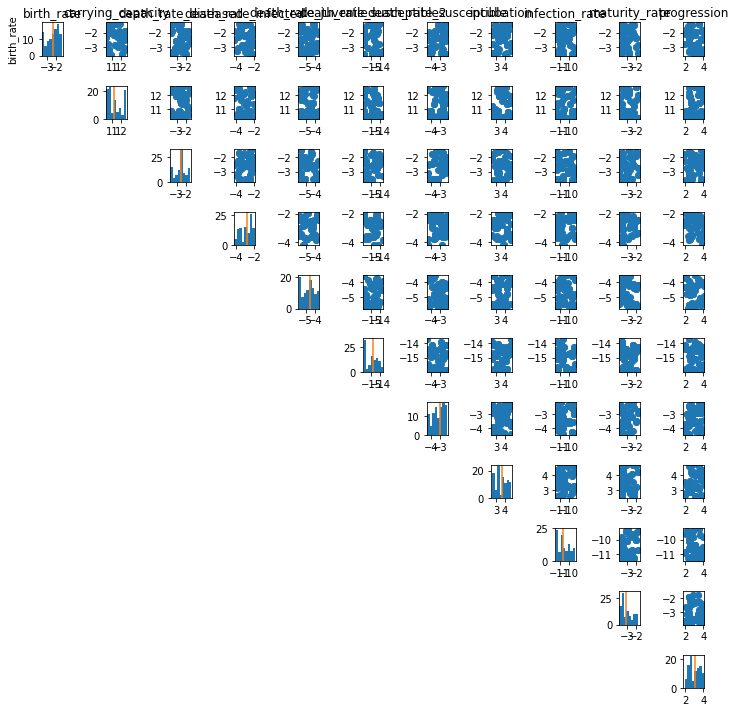

In [22]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].set_xlim(dmin[i], dmax[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(dmin[i], dmax[i])
                ax[i,j].set_xlim(dmin[j], dmax[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

In [23]:
# for i in range(posterior.shape[0]):
#     res = simulator2(posterior[i,:])
#     plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [24]:
# res = simulator2(posterior[10,:])
# print(res)
# plt.plot(res[0,:], color = 'C0', alpha = 0.02)
# #     ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
# plt.plot(obs[0,0,:], color = 'black', label = 'Observed Data')
# # ax[1].plot(obs[0,1,:], color = 'black', label = 'Observed Data')
# plt.title("Total Devil Population")
# # ax[1].set_title("Infected")
# plt.legend(loc='best')

In [33]:
np.argmin(res[1]['distances'])

94

In [36]:
res[1]['distances'][94]

22651779.872571424

In [34]:
print(posterior[94])

[ -1.49024847  10.5062799   -3.53146512  -3.58269948  -5.40559343
 -15.26939379  -3.20457699   4.07099562 -10.72042754  -2.41711756
   2.71048384]


{'birth_rate': 0.22531666497826627, 'carrying_capacity': 36544.27787104905, 'death_rate_diseased': 0.029262012063742963, 'death_rate_infected': 0.027800549720387265, 'death_rate_juvenile': 0.004491388297045836, 'death_rate_susceptible2': 2.3366116317789936e-07, 'death_rate_susceptible': 0.040576061985285974, 'incubation': 58.61529194558932, 'infection_rate': 2.208907223349948e-05, 'maturity_rate': 0.08917829887686855, 'progression': 15.03654902400587}


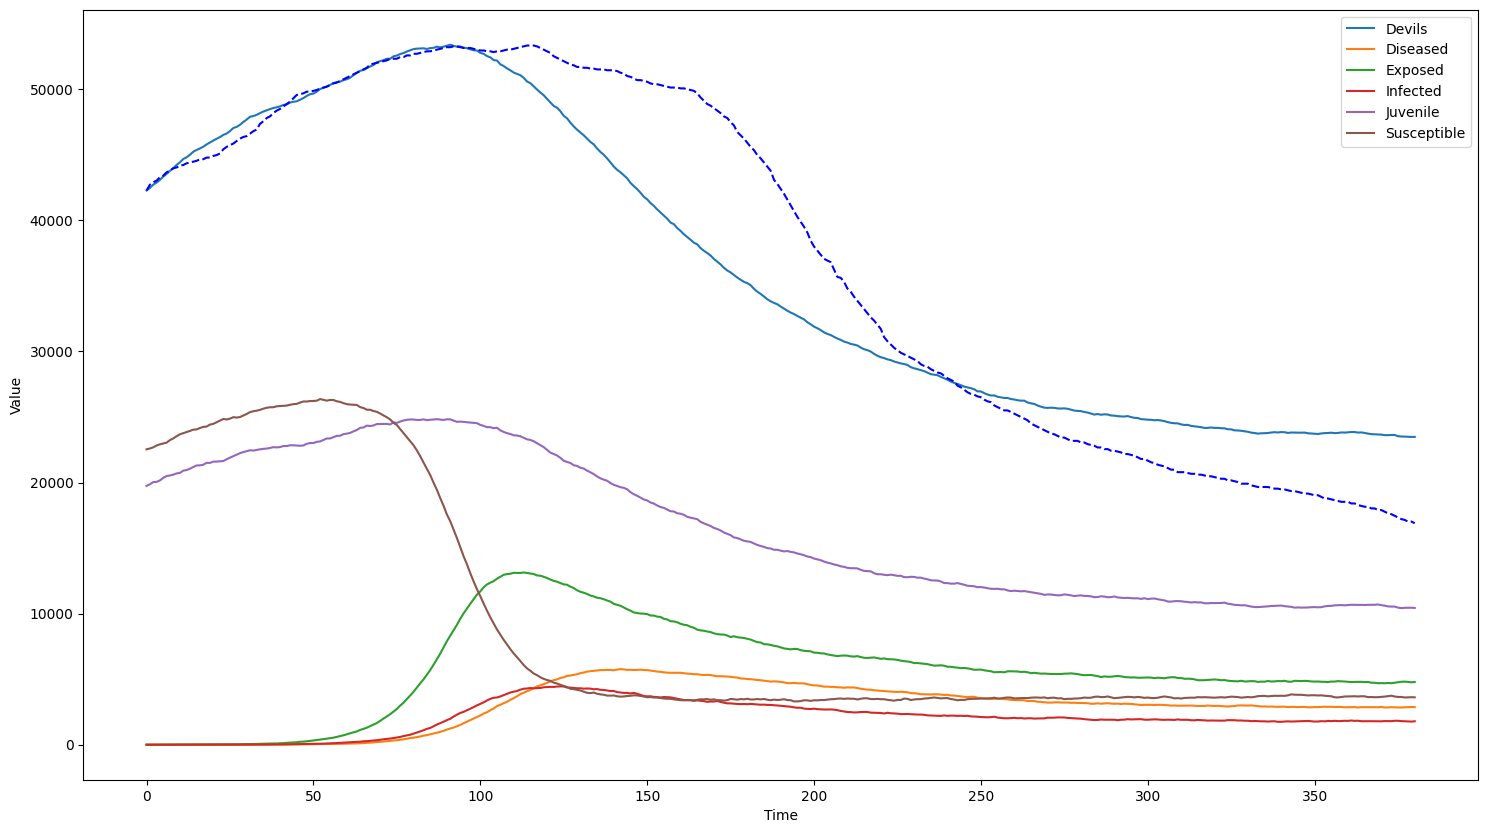

In [35]:
selected_vars = dict(zip(parameter_names, np.exp(posterior[94])))
print(selected_vars)
test = model.run(variables = selected_vars)
test.plot()
plt.plot(model.tspan, devil_pop, '--b')